# Amazon Fine Food Review, Sentiment Analysis using Machine Learning technique KNN.

About Database- All data in one sqlite database. 568,454 food reviews Amazon users left up to October 2012
Overview-
1) In this project, we have 568k * 10 size dataset. i.e. 568k rows and 10 columns(features)
2) In this dataset, we have 10 features which are as follows-
    i) Id-Row Id
    ii) ProductId- Unique identifier for the product
    iii) UserId- Unqiue identifier for the user
    iv) ProfileName- Profile name of the user
    v) HelpfulnessNumerator- Number of users who found the review helpful
    vi) HelpfulnessDenominator- Number of users who indicated whether they found the review helpful or not
    vii) Score- Rating between 1 and 5
    viii) Time- Timestamp for the review
    ix) Summary- Brief summary of the review
    x) Text- Text of the review
    
Our objective of this project is to predict whether given new review is positive or negative.    

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import cross_validation
from collections import Counter

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# we will read data
con = sqlite3.connect('database.sqlite')

# we neglect the review having Score = 3
filtered_data = pd.read_sql_query('''SELECT * FROM Reviews WHERE Score !=3''',con)

def partition(x):
    if  x < 3:
        return 'negative'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [3]:
filtered_data.shape

(525814, 10)

In [4]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
filtered_data['Score'].value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

# EDA

In [6]:
display= pd.read_sql_query( '''
                           SELECT * FROM Reviews
                           WHERE Score !=3 AND UserID= "AR5J8UI46CURR"
                           ORDER BY ProductID ''', con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


Observations:
1) As in above table, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator.Score,Time, Summary and Text shows same content 
2) Also for all 5 product, shows same time.
3) Here we observed that, product is same, only the flavour is different 
4) so we will remove this duplication and keep any one product which all these features so we removing duplicates.


In [7]:
# we will sort data according to ProductId in ascending order
sorted_data= filtered_data.sort_values('ProductId',axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
final= sorted_data.drop_duplicates(subset={'UserId', 'ProfileName','Time','Text'}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
#After removing duplications, we will see how much % of data still remains 
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [10]:
display= pd.read_sql_query(''' SELECT * FROM Reviews WHERE  Score!=3 AND Id=44737 OR Id=64422
ORDER BY ProductId''', con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


From above obsevation, it shows that HelpfulnessNumerator is greater than HelpfulnessDenominator which is pratically not possible. So these row need to be remove

In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
print(final.shape)


(364171, 10)


In [13]:
print(final['Score'].value_counts())

positive    307061
negative     57110
Name: Score, dtype: int64


Now, we do preprocessing like removal of stop words, html tags and make all letters in lowercase.

In [14]:
import re
i=0;
for sent in final['Text'].values:
    if(len(re.findall('<.*?>',sent))):
        print(i)
        print(sent)
        break;
    i+=1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [15]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

stop= set(stopwords.words('english')) #set of stopwords
sno =nltk.stem.SnowballStemmer('english')# initialising snowball stemmer

def cleanhtml(sentence): #function to clean word of any html tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean word of any punctuation or special character
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
print(stop)
print('##################################################')
print(sno.stem('tasty'))

{'which', 'been', 'with', 'ma', "mightn't", 'mightn', "mustn't", 'above', 'but', 'any', 'she', 'won', 'yours', "isn't", 'mustn', 't', "hasn't", 'what', 'o', 'shouldn', "didn't", 'y', 'or', 'as', 'his', "that'll", 'again', 'only', 'too', 'after', 'same', 'me', 'nor', 'aren', "you'll", 'once', 'weren', 'hasn', 'out', 'd', 'm', 'own', 'and', "wouldn't", "you've", 'needn', 'then', 'in', 'yourselves', 'does', 'them', 'will', 'whom', 'its', 'against', 'why', 're', 'be', 'this', 'on', 'now', 'our', 'when', 'being', 'we', 'if', 'he', 'was', 'should', "don't", 'below', 'they', "weren't", 'very', 'your', 'for', 'him', 'through', 'shan', 'here', 'wouldn', 'i', 'all', 'because', 'can', 've', 'few', 'hers', 'down', 'up', "doesn't", 'an', 'from', 'ourselves', 'over', 'couldn', 'are', "should've", "hadn't", 'at', 'most', 'were', "aren't", 'just', 'other', 'theirs', 'during', 'more', 'into', 'not', "haven't", 'has', 'before', 'didn', 'who', 'of', 'about', 'ours', 'how', 'ain', "wasn't", 'haven', 'am',

In [16]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [17]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [18]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [19]:
import sqlite3
con = sqlite3.connect('final.sqlite')

In [20]:
cleaned_data = pd.read_sql_query('select * from Reviews', con)

In [21]:
cleaned_data.shape

(364171, 12)

In [22]:
# To randomly sample 5k points from both class

data_p = cleaned_data[cleaned_data['Score'] == 'positive'].sample(n = 5000)
data_n = cleaned_data[cleaned_data['Score'] == 'negative'].sample(n = 5000)
final_10k = pd.concat([data_p, data_n])
final_10k.shape

(10000, 12)

In [23]:
# Sorting data based on time
final_10k['Time'] = pd.to_datetime(final_10k['Time'], unit = 's')
final_10k = final_10k.sort_values(by = 'Time')

# BOW

In [24]:
# Fuction to compute k value
def k_classifier_brute(X_train, y_train):
    # creating odd list of K for KNN
    myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k

In [25]:
# 7k data which will use to train model after vectorization
X = final_10k['CleanedText']
print('shape of X:', X.shape)

shape of X: (10000,)


In [26]:
# class label
y = final_10k['Score']
print('shape of y:', y.shape)

shape of y: (10000,)


In [28]:
# spliting data into 70% as train and 30% as test data 
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)

(7000,) (7000,) (3000,) (3000,)


In [29]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<7000x11374 sparse matrix of type '<class 'numpy.int64'>'
	with 222133 stored elements in Compressed Sparse Row format>

In [30]:
# Test Vectorizor
x_test = bow.transform(x_test)

In [31]:
x_test.shape

(3000, 11374)


The optimal number of neighbors is 33.


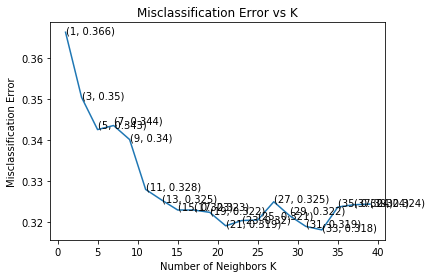

the misclassification error for each k value is :  [0.366 0.35  0.343 0.344 0.34  0.328 0.325 0.323 0.323 0.322 0.319 0.32
 0.321 0.325 0.322 0.319 0.318 0.324 0.324 0.324]


33

In [33]:
# To choose optimal_k using brute force algorithm
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation

optimal_k_bow = k_classifier_brute(X_train, y_train)
optimal_k_bow

In [34]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

In [35]:
# Accuracy on train data
train_acc_bow = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

Train accuracy 0.7185714285714285


In [36]:
# Error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

Train Error 0.281429%


In [37]:
# evaluate accuracy on test data
acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_bow, acc_bow))


The accuracy of the knn classifier for k = 33 is 68.433333%


In [38]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 739,  744],
       [ 203, 1314]], dtype=int64)

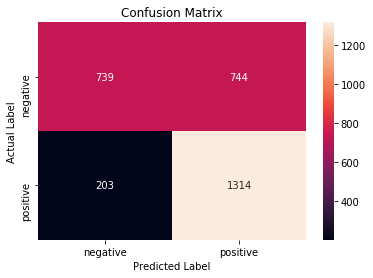

In [46]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [44]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.78      0.50      0.61      1483
   positive       0.64      0.87      0.74      1517

avg / total       0.71      0.68      0.67      3000



Observations:

1) From above figure(misclassification error vs optimal k), it is showing that classification error for each value of k, when k is increaseing the error is decreasing.
2) For example, if k = 1, error is 36%, k = 2, error is 35% and so on.
3) As I tested our model on unseen data(test data) the accuracy is 68.43 when k = 33.
4) In confusion matrix, It is clear that out of 3k unseen data-points classifier predict 2058 positive and 942 negative class label but in realilty there were 1517 positive and 1483 were negative.
5) So we can say the generalization error is quite high thats why this model does not work well with unseen data.

# Tf-IDF

In [48]:
# data
X = final_10k['CleanedText']

In [50]:
# Target/class-label
y = final_10k['Score']

In [57]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer


tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<7000x182573 sparse matrix of type '<class 'numpy.float64'>'
	with 480962 stored elements in Compressed Sparse Row format>

In [59]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_test.shape

(3000, 182573)


The optimal number of neighbors is 35.


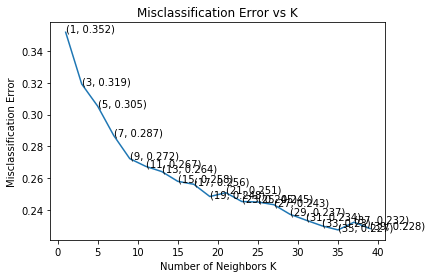

the misclassification error for each k value is :  [0.352 0.319 0.305 0.287 0.272 0.267 0.264 0.258 0.256 0.248 0.251 0.245
 0.245 0.243 0.237 0.234 0.23  0.227 0.232 0.228]


35

In [60]:
# To choosing optimal_k

optimal_k_tfidf = k_classifier_brute(X_train, y_train)
optimal_k_tfidf

In [61]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfidf)

# fitting the model
knn_optimal.fit(X_train, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)

In [65]:
# Accuracy on train data
train_acc_tfidf = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf)

Train accuracy 0.8


In [66]:
# Error on train data
train_err_tfidf = 1-train_acc_tfidf
print("Train Error %f%%" % (train_err_tfidf))

Train Error 0.200000%


In [67]:
# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfidf, acc_tfidf))


The accuracy of the knn classifier for k = 35 is 76.100000%


In [68]:
#from sklearn.matrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1083,  400],
       [ 317, 1200]], dtype=int64)

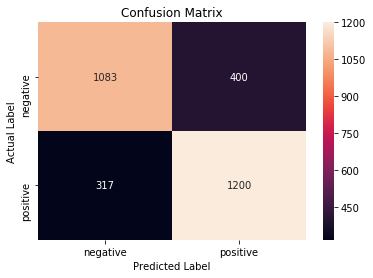

In [69]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.77      0.73      0.75      1483
   positive       0.75      0.79      0.77      1517

avg / total       0.76      0.76      0.76      3000



Observations:
1) Optimal k is 35
2) From Confusion matrix, model predicted 1600 as positive & acutal postive are 1517 and predicted 1400 as negative & actual negative are 1483 which is quite good.
3) So we can say that, this model works well

# w2v

In [78]:
# data
X = final_10k['Text']
X.shape

(10000,)

In [79]:
# Target/class-label
y = final_10k["Score"]
y.shape

(10000,)

In [80]:
X_train, x_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.3)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [81]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [85]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [86]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [87]:
w2v_model.wv.most_similar('like')

C:\Users\hp\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('enjoy', 0.7700833082199097),
 ('awful', 0.747039258480072),
 ('prefer', 0.7447276711463928),
 ('overpower', 0.7021650075912476),
 ('spicy', 0.6780746579170227),
 ('nasty', 0.6671164035797119),
 ('think', 0.6603692770004272),
 ('bitter', 0.6600927114486694),
 ('salty', 0.6515024304389954),
 ('horrible', 0.6507385969161987)]

In [88]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [89]:
w2v.shape

(5366, 50)

In [90]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [91]:
w2v_model=gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

In [92]:
w2v_model.wv.most_similar('like')

C:\Users\hp\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('really', 0.9496062397956848),
 ('but', 0.943422257900238),
 ('much', 0.9315668344497681),
 ('as', 0.9287320971488953),
 ('bad', 0.9214951395988464),
 ('just', 0.9158332943916321),
 ('taste', 0.9143046140670776),
 ('too', 0.913078784942627),
 ('does', 0.9123647212982178),
 ('good', 0.9120703935623169)]

In [93]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [94]:
w2v.shape

(3305, 50)

# Avg w2v

In [95]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

7000
50


In [96]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

3000
50


In [97]:
X_train = sent_vectors

In [98]:
x_test = sent_vectors_test


The optimal number of neighbors is 39.


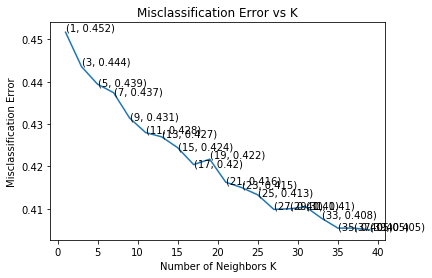

the misclassification error for each k value is :  [0.452 0.444 0.439 0.437 0.431 0.428 0.427 0.424 0.42  0.422 0.416 0.415
 0.413 0.41  0.41  0.41  0.408 0.405 0.405 0.405]


39

In [99]:
optimal_k_avgw2v = k_classifier_brute(X_train, y_train)
optimal_k_avgw2v

In [100]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgw2v)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)

In [101]:
# Accuracy on train data
train_acc_avgw2v = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_avgw2v)

Train accuracy 0.6295714285714286


In [102]:
# Error on train data
train_err_avgw2v = 1-train_acc_avgw2v
print("Train Error %f%%" % (train_err_avgw2v))

Train Error 0.370429%


In [106]:
# evaluate accuracy
acc_avg_w2v = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_avgw2v, acc_avg_w2v))


The accuracy of the knn classifier for k = 39 is 59.466667%


In [108]:
print("Test Error %f%%" %(100-(acc_avg_w2v)))

Test Error 40.533333%


In [109]:
cm = confusion_matrix(y_test, pred)
cm

array([[979, 561],
       [655, 805]], dtype=int64)

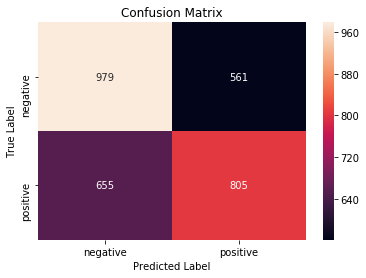

In [110]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [111]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.60      0.64      0.62      1540
   positive       0.59      0.55      0.57      1460

avg / total       0.59      0.59      0.59      3000



Observations:
1) Optimal k is 39
2) Accuarcy if model is 60%

# Tf-IDF w2v

In [112]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [113]:
len(tfidf_sent_vectors)

7000

In [114]:
X_train = tfidf_sent_vectors

In [115]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [116]:
len(tfidf_sent_vectors_test)

3000

In [117]:
x_test = tfidf_sent_vectors_test

In [120]:
X_train = np.nan_to_num(X_train)
x_test = np.nan_to_num(x_test)


The optimal number of neighbors is 17.


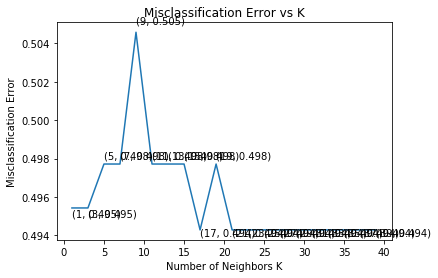

the misclassification error for each k value is :  [0.495 0.495 0.498 0.498 0.505 0.498 0.498 0.498 0.494 0.498 0.494 0.494
 0.494 0.494 0.494 0.494 0.494 0.494 0.494 0.494]


17

In [121]:
optimal_k_tfidf_w2v = k_classifier_brute(X_train, y_train)
optimal_k_tfidf_w2v

In [122]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfidf_w2v)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)

In [123]:
# Accuracy on train data
train_acc_tfidf_w2v = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf_w2v)

Train accuracy 0.4942857142857143


In [124]:
# Error on train data
train_err_tfidf_w2v = 1-train_acc_tfidf_w2v
print("Train Error %f%%" % (train_err_tfidf_w2v))

Train Error 0.505714%


In [125]:
# evaluate accuracy
acc_tfidf_w2v = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfidf_w2v, acc_tfidf_w2v))


The accuracy of the knn classifier for k = 17 is 51.333333%


In [127]:
print("Test Error %f%%" %(100-(acc_tfidf_w2v)))

Test Error 48.666667%


In [128]:
cm = confusion_matrix(y_test, pred)
cm

array([[1540,    0],
       [1460,    0]], dtype=int64)

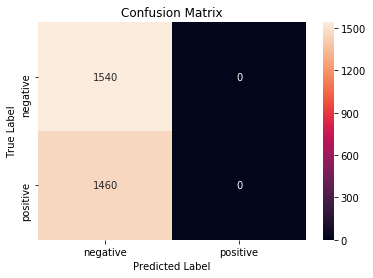

In [129]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [130]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.51      1.00      0.68      1540
   positive       0.00      0.00      0.00      1460

avg / total       0.26      0.51      0.35      3000



C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Observations:
As we observed in confusion matrix that, model predicted all reviews on the basis of majority class.
It is dull model to use.

In [131]:
# model
models = pd.DataFrame({'Model': ['KNN with Bow', "KNN with TFIDF", "KNN with Avg_w2v", "KNN with tfidf_w2v"], 'Hyper Parameter(K)': [optimal_k_bow, optimal_k_tfidf, optimal_k_avgw2v, optimal_k_tfidf_w2v], 'Train Error': [train_err_bow, train_err_tfidf, train_err_avgw2v, train_err_tfidf_w2v], 'Test Error': [100-acc_bow, 100-acc_tfidf, 100-acc_avg_w2v, 100-acc_tfidf_w2v], 'Accuracy': [acc_bow, acc_tfidf, acc_avg_w2v, acc_tfidf_w2v]}, columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K),Train Error,Test Error,Accuracy
1,KNN with TFIDF,35,0.200000,23.900000,76.100000
0,KNN with Bow,33,0.281429,31.566667,68.433333
2,KNN with Avg_w2v,39,0.370429,40.533333,59.466667
3,KNN with tfidf_w2v,17,0.505714,48.666667,51.333333


Conclusion:
As per above table, it is cleared that KNN with tf-IDF is quite good.